# Image Inpainting using a GAN
This experiment was about using a GAN, where the Generator was a pre-trained Deeplabv3 segmentation model, but only 3 output channels would be considered to represent RGB, and a pretrained classifier model called "Shufflenet" as the discriminator.
The approach was expected to work, given that the Deeplabv3 model had been pre-trained on COCO dataset, which was also being re-used, but randomly masked.
However, the results were not good, which made this option unfavorable.

In [ ]:
  !pip install fiftyone

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 676.9/676.9 kB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 kB 11.4 MB/s eta 0:00:00
  Installing build depende

In [ ]:
"""
In this work, we are going to re-construct damaged images, using torchvision's pre-trained
"""
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import torchvision
from torchvision import transforms as T
# from torchvision.models.segmentation import deeplabv3_resnet50
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import random
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [ ]:
import pandas as pd

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cuda


in this work, we want to use torchvision's pre-trained maskrcnn model as a generator, and a custom discriminator, to re-construct damaged COCO images. The images will be artificially damaged by adding a

In [ ]:
# !wget http://images.cocodataset.org/zips/test2017.zip
# !wget http://images.cocodataset.org/zips/val2017.zip

In [ ]:
import fiftyone.zoo as foz

# To download the COCO dataset for only the "person" and "car" classes
train_dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="train",
    label_types=["detections"],
    classes=["person", "car"],
    max_samples=128,
)

Migrating database to v0.23.7


INFO:fiftyone.migrations.runner:Migrating database to v0.23.7


INFO:fiftyone.zoo.datasets:Downloading split 'train' to '/root/fiftyone/coco-2017/train' if necessary


INFO:fiftyone.utils.coco:Downloading annotations to '/root/fiftyone/coco-2017/tmp-download/annotations_trainval2017.zip'


 100% |██████|    1.9Gb/1.9Gb [2.8s elapsed, 0s remaining, 739.8Mb/s]      


INFO:eta.core.utils: 100% |██████|    1.9Gb/1.9Gb [2.8s elapsed, 0s remaining, 739.8Mb/s]      


Extracting annotations to '/root/fiftyone/coco-2017/raw/instances_train2017.json'


INFO:fiftyone.utils.coco:Extracting annotations to '/root/fiftyone/coco-2017/raw/instances_train2017.json'


INFO:fiftyone.utils.coco:Downloading 128 images


 100% |██████████████████| 128/128 [14.1s elapsed, 0s remaining, 9.3 images/s]      


INFO:eta.core.utils: 100% |██████████████████| 128/128 [14.1s elapsed, 0s remaining, 9.3 images/s]      


Writing annotations for 128 downloaded samples to '/root/fiftyone/coco-2017/train/labels.json'


INFO:fiftyone.utils.coco:Writing annotations for 128 downloaded samples to '/root/fiftyone/coco-2017/train/labels.json'


Dataset info written to '/root/fiftyone/coco-2017/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/coco-2017/info.json'


Loading 'coco-2017' split 'train'


INFO:fiftyone.zoo.datasets:Loading 'coco-2017' split 'train'


 100% |█████████████████| 128/128 [1.2s elapsed, 0s remaining, 106.9 samples/s]         


INFO:eta.core.utils: 100% |█████████████████| 128/128 [1.2s elapsed, 0s remaining, 106.9 samples/s]         


Dataset 'coco-2017-train-128' created


INFO:fiftyone.zoo.datasets:Dataset 'coco-2017-train-128' created


In [ ]:
val_dataset = foz.load_zoo_dataset(
    "coco-2017",
    split="validation",
    label_types=["detections"],
    classes=["person", "car"],
    max_samples=32,
)

INFO:fiftyone.zoo.datasets:Downloading split 'validation' to '/root/fiftyone/coco-2017/validation' if necessary


Found annotations at '/root/fiftyone/coco-2017/raw/instances_val2017.json'


INFO:fiftyone.utils.coco:Found annotations at '/root/fiftyone/coco-2017/raw/instances_val2017.json'


INFO:fiftyone.utils.coco:Downloading 32 images


 100% |████████████████████| 32/32 [3.5s elapsed, 0s remaining, 9.5 images/s]      


INFO:eta.core.utils: 100% |████████████████████| 32/32 [3.5s elapsed, 0s remaining, 9.5 images/s]      


Writing annotations for 32 downloaded samples to '/root/fiftyone/coco-2017/validation/labels.json'


INFO:fiftyone.utils.coco:Writing annotations for 32 downloaded samples to '/root/fiftyone/coco-2017/validation/labels.json'


Dataset info written to '/root/fiftyone/coco-2017/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/coco-2017/info.json'


Loading 'coco-2017' split 'validation'


INFO:fiftyone.zoo.datasets:Loading 'coco-2017' split 'validation'


 100% |███████████████████| 32/32 [288.2ms elapsed, 0s remaining, 114.6 samples/s]    


INFO:eta.core.utils: 100% |███████████████████| 32/32 [288.2ms elapsed, 0s remaining, 114.6 samples/s]    


Dataset 'coco-2017-validation-32' created


INFO:fiftyone.zoo.datasets:Dataset 'coco-2017-validation-32' created


In [ ]:
train_dataset_dict  = train_dataset.to_dict()
train_imgs_paths = [i['filepath'] for i in train_dataset_dict['samples']]

 100% |█████████████████| 128/128 [779.1ms elapsed, 0s remaining, 164.3 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 128/128 [779.1ms elapsed, 0s remaining, 164.3 samples/s]      


In [ ]:
del train_dataset_dict, train_dataset

In [ ]:
val_dataset_dict  = val_dataset.to_dict()
val_imgs_paths = [i['filepath'] for i in val_dataset_dict['samples']]
del val_dataset, val_dataset_dict

 100% |███████████████████| 32/32 [355.7ms elapsed, 0s remaining, 90.0 samples/s]      


INFO:eta.core.utils: 100% |███████████████████| 32/32 [355.7ms elapsed, 0s remaining, 90.0 samples/s]      


In [ ]:
# train_imgs_paths  = [f"/root/fiftyone/coco-2017/train/data/{i}" for i in os.listdir("/root/fiftyone/coco-2017/train/data")]
# val_imgs_paths = [f"/root/fiftyone/coco-2017/validation/data/{i}" for i in os.listdir("/root/fiftyone/coco-2017/validation/data")]

In [ ]:
train_imgs_paths[0], val_imgs_paths[0]

('/root/fiftyone/coco-2017/train/data/000000000149.jpg',
 '/root/fiftyone/coco-2017/validation/data/000000005037.jpg')

In [ ]:

class ImageDataset(Dataset):
    def __init__(self, transform=None, train=True):
        self.transform = transform
        self.coco_dataset = train_imgs_paths if train else val_imgs_paths

    def __len__(self):
        return len(self.coco_dataset)

    def __getitem__(self, idx):
        image = Image.open(self.coco_dataset[idx], mode='r')

        # Convert image to RGBA if it has transparency
        if image.mode == 'P' and 'transparency' in image.info:
            image = image.convert("RGBA")

        # Convert image to RGB if it's not already
        if image.mode != 'RGB':
            image = image.convert("RGB")

        if self.transform:
            image = self.transform(image)
        image_orginal = image.detach()*1
        # Add random patches to mask parts of the image
        num_patches = random.randint(3, 5)
        patch_width = 60
        patch_height = 40

        for _ in range(num_patches):
            # print(image.shape)
            x = random.randint(0, image.shape[2] - patch_width)
            y = random.randint(0, image.shape[1] - patch_height)
            image[:,
                  y:y+patch_width,
                  x:x+patch_height
                  ] = image[:,
                  y:y+patch_width,
                  x:x+patch_height
                  ] * 0

        return image, image_orginal



# Define the transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([480, 640])
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create train and test datasets
train_dataset = ImageDataset(transform=transform, train=True)
test_dataset = ImageDataset(transform=transform, train=False)

# Define batch size for data loaders
batch_size = 8

# Create train and test data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# random.randint(0, image.shape[1] - patch_width)

In [ ]:
for i, (imgs, imgs_original) in enumerate(train_loader):
  print(i, imgs.shape, imgs_original.shape)
  break

0 torch.Size([8, 3, 480, 640]) torch.Size([8, 3, 480, 640])


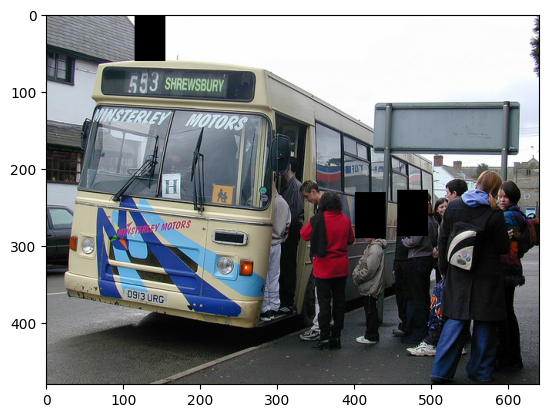

In [ ]:
plt.imshow(imgs[5].permute(1,2,0))

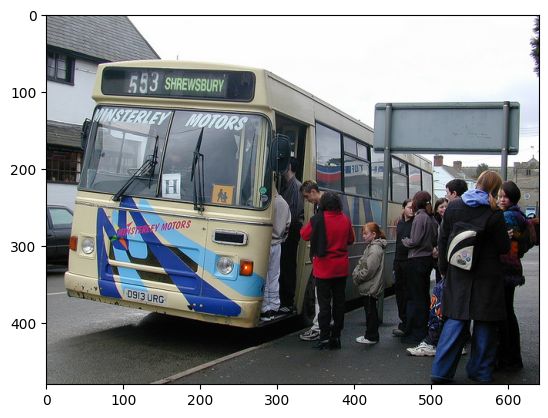

In [ ]:
plt.imshow(imgs_original[5].permute(1,2,0))

In [ ]:
class ImageGenerator(torch.nn.Module):
    def __init__(self):
        super(ImageGenerator, self).__init__()
        # Load the pre-trained Mask R-CNN model
        self.model = torchvision.models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True)

        # Replace the classifier head with a custom one
        num_classes = 3  # Predict 3 channels (RGB)
        in_features = self.model.classifier[-1].in_channels
        self.model.classifier[-1] = torch.nn.Conv2d(in_features, num_classes, kernel_size=1)

    def forward(self, x):
        # Perform the forward pass of the model
        output = self.model(x)
        output_channels = output['out'].permute(0, 1, 2, 3)
        return output_channels


class CustomDiscriminator(torch.nn.Module):
    def __init__(self):
        super(CustomDiscriminator, self).__init__()
        # Define your discriminator architecture here
        self.resize_layer = nn.Sequential(
            nn.AdaptiveAvgPool2d((224, 224))
        )
        # Load pretrained Shufflenet
        self.shufflenet = torchvision.models.shufflenet_v2_x1_0(pretrained=True)
        # Modify the last fully connected layer for binary classification
        num_classes = 1#2
        self.shufflenet.fc = nn.Linear(self.shufflenet.fc.in_features, num_classes)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        # Implement the forward pass of your discriminator here
        x = self.resize_layer(x)
        x = self.shufflenet(x)
        x = self.sigmoid(x)
        return x


# Instantiate the generator
generator = ImageGenerator().to(DEVICE)

# Instantiate the discriminator
discriminator = CustomDiscriminator().to(DEVICE)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_mobilenet_v3_large-fc3c493d.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth
100%|██████████| 42.3M/42.3M [00:00<00:00, 134MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other

In [ ]:
# Define loss function and optimizers
mse_loss = torch.nn.MSELoss()
adversarial_loss = nn.BCELoss()
optimizer_g = torch.optim.Adam(generator.parameters(), lr=0.0001)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.0001)

### Train model

In [ ]:
loss_dict = {
    "g_loss":[],
    "d_loss":[],
    "train_mse":[],
    "valid_mse":[]
}

In [ ]:
import tqdm
def train_model(generator, discriminator, data_loader, optimizer_G, optimizer_D,
                adversarial_loss, epochs):
    for epoch in range(epochs):
      # Progress Bar
      batch_bar   = tqdm.tqdm(total=len(data_loader), dynamic_ncols=True, leave=True, position=0, desc='Train', ncols=5)

      for i, (imgs, imgs_original) in enumerate((data_loader)):
            # Adversarial ground truths
            imgs=imgs.to(DEVICE)
            imgs_original=imgs_original.to(DEVICE)
            valid = torch.ones(imgs.size(0), 1).to(DEVICE)
            fake = torch.zeros(imgs.size(0), 1).to(DEVICE)

            # Train Generator
            optimizer_G.zero_grad()
            gen_imgs = generator(imgs)
            # print(gen_imgs.shape, imgs_original.shape)
            g_mse = mse_loss(gen_imgs, imgs_original)
            g_loss = adversarial_loss(discriminator(gen_imgs), valid) *0.001 + (1-0.001)* g_mse
            g_loss.backward()
            optimizer_G.step()

            # Train Discriminator
            optimizer_D.zero_grad()
            real_loss = adversarial_loss(discriminator(imgs_original), valid)
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()
            del imgs, imgs_original, gen_imgs
            # Print losses on tqdm bar
            # tqdm.tqdm.write(f"Epoch {epoch+1}/{epochs} | Batch {i+1}/{len(data_loader)} | G Loss: {g_loss.item():.4f} | D Loss: {d_loss.item():.4f} | mse: {g_mse.item():.4f}")
            batch_bar.set_postfix(
              Epoch = f"{epoch+1}/{epochs}",
              Batch =  f"{i+1}/{len(data_loader)} ",
              G_Loss =  f"{g_loss.item():.4f}",
              D_Loss =  f"{d_loss.item():.6f}",
              mse = f"{g_mse.item():.4f}",
            )

            batch_bar.update()
      batch_bar.close()
      valid_mse = validate_model(generator, test_loader)
      loss_dict["g_loss"].append(g_loss.item())
      loss_dict["d_loss"].append(d_loss.item())
      loss_dict["train_mse"].append(g_mse.item())
      loss_dict["valid_mse"].append(valid_mse)
      print("\n")



In [ ]:
def validate_model(generator, data_loader):
      # Progress Bar
      batch_bar   = tqdm.tqdm(total=len(data_loader), dynamic_ncols=True, leave=True, position=0, desc='Validation', ncols=5)
      validation_MSEs = []
      for i, (imgs, imgs_original) in enumerate((data_loader)):
            # Adversarial ground truths
            imgs=imgs.to(DEVICE)
            imgs_original=imgs_original.to(DEVICE)

            gen_imgs = generator(imgs)
            # print(gen_imgs.shape, imgs_original.shape)
            g_mse = mse_loss(gen_imgs, imgs_original)
            validation_MSEs.append(g_mse.item())
            del imgs, imgs_original, gen_imgs
            batch_bar.set_postfix(
              validation_mse = f"{g_mse.item():.4f}",
            )
            batch_bar.update()
      return sum(validation_MSEs)/len(validation_MSEs)

In [ ]:
validate_model(generator, test_loader)

Validation: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s, validation_mse=0.3715]


0.4213159456849098

In [ ]:
train_model(generator, discriminator, train_loader, optimizer_g, optimizer_d,
                adversarial_loss, epochs=100)

Validation: 100%|██████████| 4/4 [00:01<00:00,  2.63it/s, validation_mse=0.1457]


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.32it/s, validation_mse=0.0768]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.96it/s, validation_mse=0.0540]


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.17it/s, validation_mse=0.0511]


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.01it/s, validation_mse=0.0459]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.20it/s, validation_mse=0.0442]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.80it/s, validation_mse=0.0429]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.23it/s, validation_mse=0.0414]


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.00it/s, validation_mse=0.0396]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s, validation_mse=0.0381]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.90it/s, validation_mse=0.0369]


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.03it/s, validation_mse=0.0372]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.04it/s, validation_mse=0.0360]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.77it/s, validation_mse=0.0370]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.70it/s, validation_mse=0.0353]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.75it/s, validation_mse=0.0367]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.91it/s, validation_mse=0.0346]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.34it/s, validation_mse=0.0342]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.81it/s, validation_mse=0.0363]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.01it/s, validation_mse=0.0317]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.59it/s, validation_mse=0.0330]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.99it/s, validation_mse=0.0339]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.86it/s, validation_mse=0.0309]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s, validation_mse=0.0335]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.24it/s, validation_mse=0.0325]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.71it/s, validation_mse=0.0297]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.62it/s, validation_mse=0.0322]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.77it/s, validation_mse=0.0297]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.84it/s, validation_mse=0.0300]


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.87it/s, validation_mse=0.0311]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.42it/s, validation_mse=0.0319]


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s, validation_mse=0.0284]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.74it/s, validation_mse=0.0282]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.84it/s, validation_mse=0.0288]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.82it/s, validation_mse=0.0300]


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.02it/s, validation_mse=0.0292]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.09it/s, validation_mse=0.0284]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.91it/s, validation_mse=0.0279]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.88it/s, validation_mse=0.0292]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.54it/s, validation_mse=0.0285]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.95it/s, validation_mse=0.0283]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.18it/s, validation_mse=0.0281]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.52it/s, validation_mse=0.0278]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.46it/s, validation_mse=0.0294]


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.16it/s, validation_mse=0.0284]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.48it/s, validation_mse=0.0272]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.20it/s, validation_mse=0.0304]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.65it/s, validation_mse=0.0258]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.50it/s, validation_mse=0.0266]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.75it/s, validation_mse=0.0243]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.87it/s, validation_mse=0.0254]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.14it/s, validation_mse=0.0266]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.64it/s, validation_mse=0.0252]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.44it/s, validation_mse=0.0267]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.97it/s, validation_mse=0.0265]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.79it/s, validation_mse=0.0263]


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.96it/s, validation_mse=0.0276]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.66it/s, validation_mse=0.0263]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.21it/s, validation_mse=0.0280]


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.02it/s, validation_mse=0.0264]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.89it/s, validation_mse=0.0255]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s, validation_mse=0.0245]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.94it/s, validation_mse=0.0264]


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.85it/s, validation_mse=0.0238]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.82it/s, validation_mse=0.0236]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.69it/s, validation_mse=0.0256]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.09it/s, validation_mse=0.0260]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.97it/s, validation_mse=0.0273]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.02it/s, validation_mse=0.0234]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s, validation_mse=0.0240]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.68it/s, validation_mse=0.0251]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.71it/s, validation_mse=0.0234]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.89it/s, validation_mse=0.0262]


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.82it/s, validation_mse=0.0251]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.89it/s, validation_mse=0.0267]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s, validation_mse=0.0238]


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.02it/s, validation_mse=0.0241]


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.11it/s, validation_mse=0.0229]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.33it/s, validation_mse=0.0229]


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.01it/s, validation_mse=0.0260]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.80it/s, validation_mse=0.0231]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.86it/s, validation_mse=0.0238]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.84it/s, validation_mse=0.0234]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.20it/s, validation_mse=0.0231]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.78it/s, validation_mse=0.0255]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.96it/s, validation_mse=0.0213]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.73it/s, validation_mse=0.0242]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.99it/s, validation_mse=0.0237]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.20it/s, validation_mse=0.0224]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.76it/s, validation_mse=0.0247]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.94it/s, validation_mse=0.0236]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.84it/s, validation_mse=0.0240]


Validation: 100%|██████████| 4/4 [00:00<00:00,  5.11it/s, validation_mse=0.0220]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.25it/s, validation_mse=0.0208]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.81it/s, validation_mse=0.0257]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.75it/s, validation_mse=0.0214]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.98it/s, validation_mse=0.0255]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.64it/s, validation_mse=0.0228]


Validation: 100%|██████████| 4/4 [00:01<00:00,  3.93it/s, validation_mse=0.0237]


Validation: 100%|██████████| 4/4 [00:00<00:00,  4.91it/s, validation_mse=0.0230]

In [ ]:
0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
gen_imgs = generator(imgs.to(DEVICE))

In [ ]:
gen_imgs.shape

torch.Size([8, 3, 480, 640])

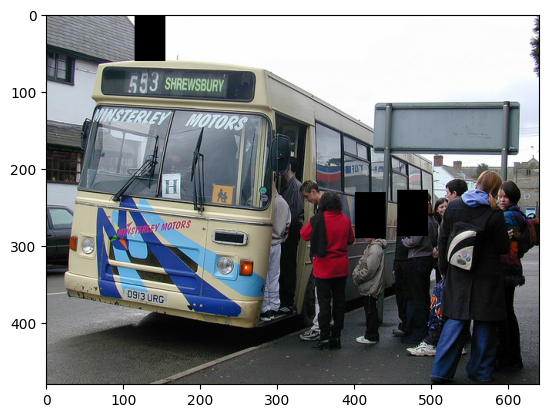

In [ ]:


plt.imshow(imgs[5].permute(1,2,0).detach().cpu())

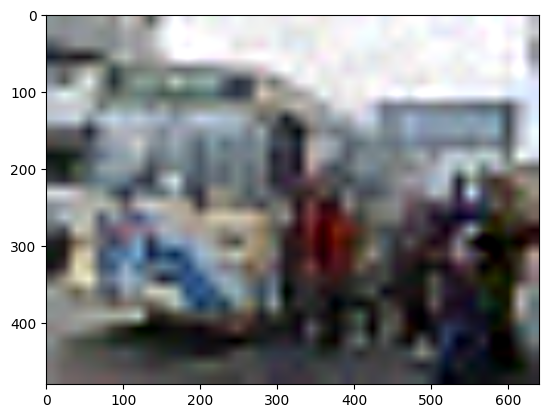

In [ ]:
plt.imshow(gen_imgs[5].permute(1,2,0).detach().cpu())

In [ ]:
pd.DataFrame(loss_dict).to_csv("loss_dict.csv")

dict_keys(['g_loss', 'd_loss', 'train_mse', 'valid_mse'])


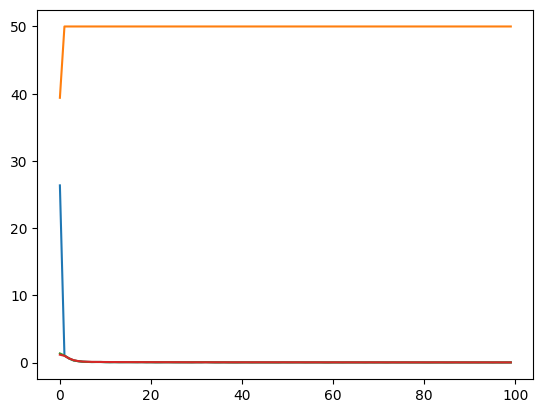

In [ ]:
print(loss_dict.keys())
plt.plot(loss_dict['g_loss'])
plt.plot(loss_dict['d_loss'])
plt.plot(loss_dict['train_mse'])
plt.plot(loss_dict['valid_mse'])

